In [29]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import linear_model 
from sklearn import metrics 
from sklearn.feature_selection import RFECV 
from sklearn.svm import SVR 
from sklearn.model_selection import cross_val_score
import pickle

In [30]:
#Select the Store and Version of Clustered Data 
Store = 160
data = pd.read_csv('Store'+str(Store)+'\Store'+str(Store)+'_order_15-min-cluster_20180103-20190711.csv',index_col=0)

data['BusinessDate'] = pd.to_datetime(data['BusinessDate'])
#Specify Date-Time Variable Types
date_time = ['OrderStartDateTime','NormalDateTime','BumpedDateTime','CookingDateTime','DayHalfHour','DayQuarterHour']
for i in date_time:
    data.loc[:,i] = pd.to_datetime(data.loc[:,i], format="%Y-%m-%d %H:%M:%S.%f") 

In [31]:
data.columns 

Index(['StoreKey', 'BusinessDate', 'TimeKey', 'CheckNum', 'GuestCount',
       'TableOpenMinutes', 'ProductKey', 'CourseName', 'IXIName',
       'MajorCodeName', 'MinorCodeName', 'StationName', 'SentTime',
       'OrderStartDateTime', 'NormalDateTime', 'CookingDateTime',
       'BumpedDateTime', 'NatHolidayDesc', 'EmployeeKey', 'TicketTime', 'RNK',
       'PROD_RNK', 'ORDER_RNK', 'StationKey', 'DateKey', 'TypeofServiceNum',
       'ChannelKey', 'OpenHour', 'OpenMinute', 'CloseHour', 'CloseMinute',
       'TypeofServiceCat', 'ChannelName', 'StartTime', 'OffSiteOrder',
       'OnSiteOrder', 'TotalOrder', 'OnSiteItem', 'OffSiteItem', 'TotalItem',
       'HalfHourStart', 'QuarterHour', 'HalfHour', 'Hour', 'DayHalfHour',
       'DayQuarterHour', 'DayOfWeek', 'DayOfWeekName', 'Week', 'Weekday',
       'OrderTimeMin', 'Holiday', 'BumpedDateTime_fill', 'OpenDateTime',
       'CloseDateTime', 'OnSiteOrder_fill', 'OffSiteOrder_fill',
       'OnSiteItem_fill', 'OffSiteItem_fill', 'OnSiteGuest', '

In [32]:
#Make sure to run this when using Punch Data as the source of Labor at Station
#Check in labor_st contains names of labor at staions
labor_st = list(data.columns[63:])

In [33]:
data.shape 

(256103, 64)

# Visualization by Variable

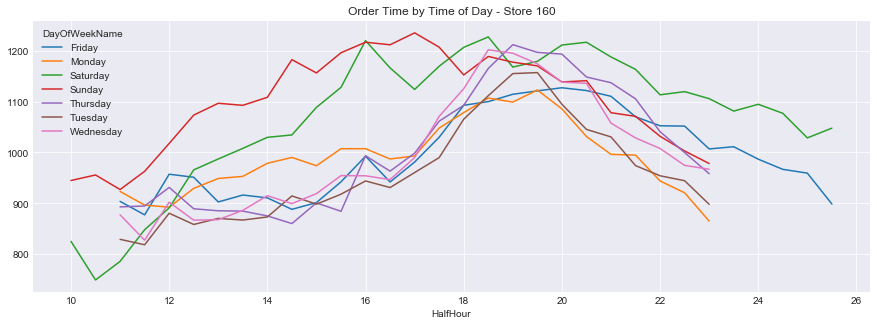

In [34]:
#Order Time by Day of Week & Time of Day (30 min)
data.groupby(['HalfHour','DayOfWeekName'])['OrderTime'].mean().unstack().plot(kind='line',legend='True',figsize=(15,5),title='Order Time by Time of Day - Store '+str(Store)) 

# Merge Labor Variable

## Labor by Category

In [35]:
labor = pd.read_csv('labor_20180103-20190711.csv')
labor = labor[labor['StoreKey']==Store]
#Specify Variable Type for Date Time Variable
labor.loc[:,'BusinessDate'] = pd.to_datetime(labor.loc[:,'BusinessDate'])

#Clean Hour Description
labor['Hour'] = np.where(labor['HourDescription'].str.contains('PM'), labor['HourDescription'].str.slice(0,2).str.replace(' ','').astype('int')+12, labor['HourDescription'].str.slice(0,2).str.replace(' ','').astype('int'))
labor['Hour'] = np.where(labor['Hour']==12,0,labor['Hour'])
labor['Hour'] = np.where(labor['Hour']==24,12,labor['Hour'])
labor.columns= ['BusinessDate','StoreKey', 'LaborCategory','HourDescription','ActualLaborHrs','Hour']
labor.head()

,BusinessDate,StoreKey,LaborCategory,HourDescription,ActualLaborHrs,Hour
29037,2018-06-26,160,Prep,1 AM,0.38,1
29038,2018-06-26,160,Dishwasher,1 AM,0.65,1
29039,2018-06-26,160,Bar,1 AM,0.52,1
29040,2018-06-26,160,Busser,1 AM,1.22,1
29041,2018-06-26,160,Cook,1 PM,3.12,13


In [36]:
#Merge Each Labor Category into data
labor_cat = []
for i in labor['LaborCategory'].unique(): 
    r = labor[labor['LaborCategory'] == i][['StoreKey','BusinessDate','Hour','ActualLaborHrs']]
    r.columns = ['StoreKey','BusinessDate','Hour','LaborHrs_'+i]
    data = data.merge(right = r, how = 'left', on = ['StoreKey','BusinessDate','Hour'])
    data['LaborHrs_'+i] = np.where(pd.isna(data['LaborHrs_'+i]),0,data['LaborHrs_'+i])
    labor_cat.append('LaborHrs_'+i)

In [37]:
labor['BusinessDate'].min()

Timestamp('2018-06-26 00:00:00')

In [38]:
labor['BusinessDate'].max()

Timestamp('2019-07-11 00:00:00')

## Labor at Station

In [39]:
labor1 = pd.read_csv('Store'+str(Store)+'\Store'+str(Store)+'_employee_labor_20180103-20190711.csv')
labor1['BusinessDate'] = pd.to_datetime(labor1['BusinessDate'])
labor1.head()

,BusinessDate,StoreKey,Hour,EmployeeKey,JobName,LaborCategoryName,ActualLaborMinutes
0,2018-06-26,160,7,63032,Prep Cook,Prep,40
1,2018-06-26,160,8,63032,Prep Cook,Prep,60
2,2018-06-26,160,9,63032,Prep Cook,Prep,60
3,2018-06-26,160,10,63032,Prep Cook,Prep,60
4,2018-06-26,160,11,63032,Prep Cook,Prep,60


In [40]:
schedule = pd.read_csv('employee_station_20180103-20190711.csv')
schedule = schedule[schedule['StoreKey']==Store]
schedule['BusinessDate'] = pd.to_datetime(schedule['BusinessDate'])
schedule['StartTime'] = pd.to_datetime(schedule['StartTime'])
schedule['EndTime'] = pd.to_datetime(schedule['EndTime'])
schedule['LocationName'] = schedule['LocationName'].str.lower()
schedule.head()

,BusinessDate,StoreKey,EmployeeKey,JobName,LaborCategoryName,StartTime,EndTime,LocationName
21475,2018-02-20,160,268579,Line Cook1,Cook,2018-02-20 09:00:00,2018-02-20 16:00:00,saladst
21476,2018-02-20,160,140930,Line Cook1,Cook,2018-02-20 09:00:00,2018-02-20 16:00:00,broilck
21477,2018-02-20,160,107746,Line Cook1,Cook,2018-02-20 09:00:00,2018-02-20 16:00:00,grillck
21478,2018-02-20,160,63897,Line Cook1,Cook,2018-02-20 09:00:00,2018-02-20 16:00:00,pizzast
21479,2018-02-20,160,169393,Line Cook1,Cook,2018-02-20 09:00:00,2018-02-20 16:00:00,fryck


In [13]:
Station = pd.Series(data['StationName'].unique()).str.lower()
s_clean = [i.replace('broiler', 'broil') for i in Station]
s_clean = [i.replace('sandwich', 'sand') for i in s_clean]
s_clean = [i.replace('apps', 'app') for i in s_clean]
s_sort = [i for i in s_clean if (' / ' not in i)] + [i for i in s_clean if (' / ' in i)]

schedule['AtStation'] = None
labor_st = []
for i in s_sort:
    name = 'Labor_'+str(i)
    labor_st.append(name)
    if ' / ' not in i: 
        schedule[name] = np.where(schedule['LocationName'].str.contains(i),1,0)
        schedule['AtStation'] = np.where(schedule['LocationName'].str.contains(i),1,schedule['AtStation'])
    elif ' / ' in i: #if combo station, must contain key words from both station 
        i1,i2  = i.split(' / ')
        print(i1,i2)
        schedule[name] = np.where(((schedule['LocationName'].str.contains(i1))|(schedule['LocationName'].str.contains(i2)))&(pd.isnull(schedule['AtStation'])),1,0)
        schedule['AtStation'] = np.where(((schedule['LocationName'].str.contains(i1))|(schedule['LocationName'].str.contains(i2)))&(pd.isnull(schedule['AtStation'])),1,schedule['AtStation'])


broil app
grill fry
pasta saute


In [14]:
station_location = {}
for i in s_sort: 
    name = 'Labor_'+str(i)
    station_location[i] = schedule[schedule[name]==1]['LocationName'].unique()
station_location

{'saute': array(['sautest', 'sautepl', 'sautefl', 'sautemd'], dtype=object),
 'salad': array(['saladst', 'saladpr', 'saladfn', 'saladmd'], dtype=object),
 'fry': array(['fryck', 'frypl'], dtype=object),
 'pizza': array(['pizzast', 'pizzafn'], dtype=object),
 'sand': array([], dtype=object),
 'broil / app': array(['broilck', 'broilpl', 'broilmd'], dtype=object),
 'grill / fry': array(['grillck', 'grillpl'], dtype=object),
 'pasta / saute': array(['pastast', 'pastapl', 'pastafl', 'pastamd'], dtype=object)}

In [15]:
schedule['LocationName'].unique()

array(['saladst', 'broilck', 'grillck', 'pizzast', 'fryck', 'pastast',
       'sautest', 'scraping', 'racking', 'cleansd', 'potwash', 'fill1',
       'greet1', '.din 16', '.din 13', '.din 06', '.din 02', 'bar 01',
       '.din 09', '.din 04', '.din 14', 'bar 04', '.din 10', 'ost',
       'oven', 'saladpr', 'slicer', 'sauceck', 'prodrl', 'pprepcr',
       'cash1', 'dessert 1', 'crbcsh1', 'barcw1', 'busd01', 'busd05',
       'busd04', 'upfdrn1', 'portion', 'no_location', 'napkin1',
       'train cook', 'train fd', 'kitchfl', 'steward', 'strbar',
       '.din 15', 'bar 02', 'cash2', 'dessert 2', 'barcw2', 'barmw1',
       'busd03', 'busd02', 'fdrun2', 'frypl', 'pastapl', 'sautepl',
       'dsfloat', 'dskrun1', 'dskrun2', 'crowd1', '.din 11', '.din 07',
       '.din 05', '.din 08', '.din 17', '.din 12', 'bar 03', '.din 03',
       'fdrun3', 'fdrun5', 'fdrun4', 'carts', 'train bake', 'pprepfl',
       'train bus', 'bsrncpt', '.din 01', 'train bar', 'train server',
       'scrape', 'busb03',

In [16]:
#Uncategorized Location
list(schedule[pd.isnull(schedule['AtStation'])]['LocationName'].unique())

['scraping',
 'racking',
 'cleansd',
 'potwash',
 'fill1',
 'greet1',
 '.din 16',
 '.din 13',
 '.din 06',
 '.din 02',
 'bar 01',
 '.din 09',
 '.din 04',
 '.din 14',
 'bar 04',
 '.din 10',
 'ost',
 'oven',
 'slicer',
 'sauceck',
 'prodrl',
 'pprepcr',
 'cash1',
 'dessert 1',
 'crbcsh1',
 'barcw1',
 'busd01',
 'busd05',
 'busd04',
 'upfdrn1',
 'portion',
 'no_location',
 'napkin1',
 'train cook',
 'train fd',
 'kitchfl',
 'steward',
 'strbar',
 '.din 15',
 'bar 02',
 'cash2',
 'dessert 2',
 'barcw2',
 'barmw1',
 'busd03',
 'busd02',
 'fdrun2',
 'dsfloat',
 'dskrun1',
 'dskrun2',
 'crowd1',
 '.din 11',
 '.din 07',
 '.din 05',
 '.din 08',
 '.din 17',
 '.din 12',
 'bar 03',
 '.din 03',
 'fdrun3',
 'fdrun5',
 'fdrun4',
 'carts',
 'train bake',
 'pprepfl',
 'train bus',
 'bsrncpt',
 '.din 01',
 'train bar',
 'train server',
 'scrape',
 'busb03',
 'strbake',
 'upcrwd1',
 'train dish',
 'prodfl',
 'pat 01',
 'pat 02',
 'pat 03',
 'train prep',
 'upcarts',
 'do not use',
 'upgrt1',
 'busp01',
 '

In [17]:
#Keep the relationship between Employee and Station
employee_station = schedule[pd.isnull(schedule['AtStation'])==False].drop(columns=['JobName','LaborCategoryName','StartTime','EndTime','LocationName'])

In [18]:
labor2 = labor1.merge(right=employee_station, on=['StoreKey','EmployeeKey','BusinessDate']) 
labor2 = labor2.drop(columns='EmployeeKey').groupby(['StoreKey','BusinessDate','Hour']+labor_st).sum().reset_index()

#Fill in Hours worked at Station during the Hour period
for i in labor_st:
    labor2.loc[:,i] = labor2.loc[:,i]*labor2.loc[:,'ActualLaborMinutes'] / 60
labor2 = labor2.drop(columns='ActualLaborMinutes')

In [19]:
labor2 = labor2.groupby(['StoreKey','BusinessDate','Hour']).sum().reset_index() 

In [20]:
data = data.merge(right=labor2,how='left',on=['StoreKey','BusinessDate','Hour'])

In [21]:
data.columns

Index(['StoreKey', 'BusinessDate', 'TimeKey', 'CheckNum', 'GuestCount',
       'TableOpenMinutes', 'ProductKey', 'CourseName', 'IXIName',
       'MajorCodeName', 'MinorCodeName', 'StationName', 'SentTime',
       'OrderStartDateTime', 'NormalDateTime', 'CookingDateTime',
       'BumpedDateTime', 'NatHolidayDesc', 'EmployeeKey', 'TicketTime', 'RNK',
       'PROD_RNK', 'ORDER_RNK', 'StationKey', 'DateKey', 'TypeofServiceNum',
       'ChannelKey', 'OpenHour', 'OpenMinute', 'CloseHour', 'CloseMinute',
       'TypeofServiceCat', 'ChannelName', 'StartTime', 'OffSiteOrder',
       'OnSiteOrder', 'TotalOrder', 'OnSiteItem', 'OffSiteItem', 'TotalItem',
       'HalfHourStart', 'QuarterHour', 'HalfHour', 'Hour', 'DayHalfHour',
       'DayQuarterHour', 'DayOfWeek', 'DayOfWeekName', 'Week', 'Weekday',
       'OrderTimeMin', 'Holiday', 'BumpedDateTime_fill', 'OpenDateTime',
       'CloseDateTime', 'OnSiteOrder_fill', 'OffSiteOrder_fill',
       'OnSiteItem_fill', 'OffSiteItem_fill', 'OnSiteGuest', '

In [22]:
#NA creates for time slots with no time worked (?), fill in 0
data.loc[:,labor_st] = data.loc[:,labor_st].fillna(0)

In [23]:
labor1['BusinessDate'].min()

Timestamp('2018-06-26 00:00:00')

In [24]:
labor1['BusinessDate'].max()

Timestamp('2019-07-11 00:00:00')

In [25]:
schedule['BusinessDate'].min()

Timestamp('2018-01-03 00:00:00')

In [26]:
schedule['BusinessDate'].max()

Timestamp('2019-07-11 00:00:00')

In [41]:
# Align the begining dates
data = data[data['BusinessDate']>-'2018-06-26']

TypeError: bad operand type for unary -: 'str'

In [27]:
del labor1
del schedule

# Trend Visualization

In [ ]:
data['L'] = data['LaborHrs_Cook'].astype('str')+' '+data['LaborHrs_Prep'].astype('str')+' '+data['LaborHrs_Server'].astype('str')

In [ ]:
data['L'].value_counts()

In [ ]:
# Ticket Time at Station (with fixed labor hrs)
s = data['StationN']
plt_data = data[((data['LaborHrs_Cook']>=6)&(data['LaborHrs_Cook']==7))&(data['LaborHrs_Server']>=10)]
#plt_data = data[((data['LaborHrs_Cook']>=6)|(data['LaborHrs_Cook']<=9))&(data['LaborHrs_Prep']==1)&(data['LaborHrs_Server']>=12)]
plt.figure(figsize=(12,6))
plt.scatter(plt_data['TotalItem'],plt_data['OrderTime-Min'],color='grey')
d = plt_data.groupby('TotalItem').agg({'OrderTime-Min':['count','median']}).reset_index()
d = d[d[('OrderTime-Min','count')]>5]
plt.plot(d['TotalItem'],d[('OrderTime-Min','median')],linewidth=3)
plt.xlabel('#Total Concurrent Items',fontsize=12)
plt.ylabel('Order Time (in minutes)',fontsize=12)
plt.title('Order Time by Concurrent Items',fontsize=16)



# Modeling

## Linear

In [38]:
#Check if Dates from different Sources Align
data = data[data['BusinessDate']>='2018-06-26'] 

### Forecasting

In [373]:
ot_data['diff'] = (ot_data['OrderTime']-ot_data['pred'])**2

In [134]:
#ot_data.sort_values(by='diff',ascending=False)[['DayOfWeek','QuarterHour','OrderTime','pred']]

### Visualize Modeling Result

# Lasso

In [ ]:
#Lasso Tuning
CVresult = []
for a in np.arange(0,1,0.05):
    reg1 = linear_model.Lasso(alpha=a) 
    score = cross_val_score(reg1, reg_X, reg_data['OrderTime'], cv=5,scoring='r2')
    CVresult.append([a,sum(score)/5])
CV = pd.DataFrame(CVresult,columns = ['alpha','score'])

In [ ]:
CV

In [ ]:
# Lasso
reg1 = linear_model.Lasso(alpha=0.1)
reg1.fit(train_X, train_data['OrderTime'])
coef1 = pd.DataFrame({'Variable':train_X.columns,'Coef':reg1.coef_}) 
# Prediction
train_data['pred'] = reg1.predict(train_X)
test_data['pred'] = reg1.predict(test_X)
ot_data['pred'] = reg1.predict(ot_X)

print('training R^2', metrics.r2_score(train_data['OrderTime'],train_data['pred']))
print('testing R^2', metrics.r2_score(test_data['OrderTime'],test_data['pred']))
print('out-of-time R^2', metrics.r2_score(ot_data['OrderTime'],ot_data['pred']))

## Neural Net

In [45]:
var = ['OrderTime','BusinessDate','StartTime','DayOfWeek','QuarterHour','OffSiteOrder','OnSiteOrder','OnSiteItem','OffSiteItem','GuestCount','OnSiteGuest','Holiday','Class']+labor_cat+labor_st
var_remove = ['OrderTime','DayOfWeek','QuarterHour','BusinessDate','StartTime']

reg_data = data[(data['BusinessDate']<=pd.to_datetime('2019-06-18'))][var].reset_index().drop(columns='index')
ot_data = data[(data['BusinessDate']>=pd.to_datetime('2019-06-19'))&(data['BusinessDate']<='2019-06-25')][var].reset_index().drop(columns='index') 

In [46]:
#Spliting Training & Testing
from random import sample
n_total = len(reg_data)
n_train = round(n_total*0.8)
train = sample(range(n_total),n_train) 

train_data = reg_data.loc[train,:]
test_data = reg_data.drop(index=train)
reg_X = reg_data.drop(columns = var_remove)
train_X = train_data.drop(columns = var_remove)
test_X = test_data.drop(columns = var_remove)
ot_X  = ot_data.drop(columns = var_remove)

In [47]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(reg_X)
reg_X_trans = scaler.transform(reg_X)    
ot_X_trans = scaler.transform(ot_X)

In [354]:
from sklearn.neural_network import MLPRegressor 

In [84]:
CVresult = []
for a in np.arange(0.5,1,0.1):
    for s in np.arange(10,140,20):
        nn1 = MLPRegressor(hidden_layer_sizes=s, alpha=a,learning_rate='adaptive') 
        score = cross_val_score(nn1, reg_X_trans, reg_data['OrderTime'], cv=5, scoring='r2')
        CVresult.append([a,s,sum(score)/5])
        print(a,s,score)
CV = pd.DataFrame(CVresult,columns = ['alpha','size','score']) 

C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.5 10 [0.21878877 0.21451789 0.21026038 0.20968993 0.21205298]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.5 30 [0.23338813 0.23213141 0.22352174 0.22284328 0.2260906 ]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.5 50 [0.23615707 0.23501575 0.22617386 0.22804743 0.23024706]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.5 70 [0.23749938 0.23782763 0.22745373 0.2298077  0.23207426]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.5 90 [0.24020804 0.23743716 0.22917954 0.23154936 0.23301981]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.5 110 [0.2402627  0.23829997 0.22989794 0.23151922 0.23426091]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.5 130 [0.24145155 0.23979641 0.22965675 0.23340147 0.23604308]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.6 10 [0.21765419 0.21866594 0.21499498 0.20574809 0.20578181]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.6 30 [0.23039519 0.23080763 0.22453053 0.22435537 0.22789751]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.6 50 [0.23701983 0.23595422 0.22877446 0.2286509  0.22947563]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.6 70 [0.237236   0.23763727 0.22808323 0.23002693 0.23089397]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.6 90 [0.24025273 0.2372945  0.22877014 0.23140224 0.2321555 ]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.6 110 [0.24119495 0.23865918 0.23053303 0.23260514 0.23373493]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.6 130 [0.24169786 0.23987937 0.23005057 0.23430731 0.23537881]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7 10 [0.21552125 0.22326758 0.21381493 0.21185398 0.216149  ]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7 30 [0.23096035 0.23106552 0.22550943 0.22117561 0.22740079]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7 50 [0.23371231 0.23531314 0.22743298 0.22899229 0.22970051]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7 70 [0.23660295 0.23524739 0.2285962  0.23093447 0.23020029]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7 90 [0.24022344 0.23805226 0.22925252 0.23299057 0.23369278]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7 110 [0.24021008 0.23915936 0.22964144 0.23007493 0.23510093]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7 130 [0.24012184 0.23979565 0.22985983 0.23535628 0.23507193]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7999999999999999 10 [0.21839972 0.22511378 0.21532716 0.20929987 0.21322956]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7999999999999999 30 [0.23270666 0.23216033 0.22417638 0.22459987 0.22793807]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7999999999999999 50 [0.2368818  0.2367134  0.22732718 0.22833109 0.22992252]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7999999999999999 70 [0.23995155 0.23708899 0.22775998 0.22925295 0.23124666]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7999999999999999 90 [0.23774118 0.23764475 0.22996953 0.23094115 0.23303956]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7999999999999999 110 [0.24195319 0.23895196 0.22952439 0.23350696 0.23688337]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.7999999999999999 130 [0.24062691 0.24058161 0.23021943 0.23299588 0.2353057 ]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.8999999999999999 10 [0.2213523  0.22017819 0.21027899 0.21094944 0.20895297]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.8999999999999999 30 [0.2324301  0.23065368 0.22122516 0.22498584 0.22748244]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.8999999999999999 50 [0.23790421 0.23494337 0.22752239 0.22864182 0.22992407]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.8999999999999999 70 [0.23897195 0.23520689 0.22908255 0.22950833 0.2326272 ]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.8999999999999999 90 [0.23911882 0.23918463 0.22903915 0.23233722 0.23358371]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda

0.8999999999999999 110 [0.24088241 0.23878886 0.23050726 0.23290125 0.23358764]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8999999999999999 130 [0.24182043 0.23997708 0.23069916 0.2339618  0.23448504]


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [86]:
CV

,alpha,size,score
0,0.5,10,0.213062
1,0.5,30,0.227595
2,0.5,50,0.231128
3,0.5,70,0.232933
4,0.5,90,0.234279
5,0.5,110,0.234848
6,0.5,130,0.236070
7,0.6,10,0.212569
8,0.6,30,0.227597
9,0.6,50,0.231975


In [313]:
%%time
layer = 130
alpha = 0.9
nn = MLPRegressor(hidden_layer_sizes=layer,alpha=alpha,learning_rate='adaptive')
nn.fit(reg_X_trans, reg_data['OrderTime'])

Wall time: 3min 28s


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [315]:
reg_data['pred'] = nn.predict(reg_X_trans)
ot_data['pred'] = nn.predict(ot_X_trans)

print('training R^2', metrics.r2_score(reg_data['OrderTime'],reg_data['pred']))
print('out-of-time R^2', metrics.r2_score(ot_data['OrderTime'],ot_data['pred']))

print('training RMSE', metrics.mean_squared_error(reg_data['OrderTime'],reg_data['pred'])**0.5)
print('out-of-time RMSE', metrics.mean_squared_error(ot_data['OrderTime'],ot_data['pred'])**0.5)

training R^2 0.25016125229390873
out-of-time R^2 0.10456226084581022
training RMSE 319.3771712639436
out-of-time RMSE 331.6525127099561


In [ ]:
layer = 130
alpha = 0.9

In [ ]:
#Save the Model
filename = 'Store'+str(Store)+'\Store'+str(Store)+'StoreNeural Net Model-'+str(layer)+'-'+str(alpha)+'.sav'
pickle.dump(nn,open(filename,'wb'))

In [404]:
ot_data['diff'] = (ot_data['OrderTime']-ot_data['pred'])**2

## Random Forest

In [54]:
from sklearn.ensemble import RandomForestRegressor 

In [55]:
%%time
rf = RandomForestRegressor(max_depth=5, min_samples_leaf=30, random_state=0,n_estimators=1500)
rf.fit(train_X_trans, train_data['OrderTime']) 

Wall time: 11min 23s


In [56]:
train_data['pred'] = rf.predict(train_X_trans)
test_data['pred'] = rf.predict(test_X_trans)
ot_data['pred'] = rf.predict(ot_X_trans)

print('training R^2', metrics.r2_score(train_data['OrderTime'],train_data['pred']))
print('testing R^2', metrics.r2_score(test_data['OrderTime'],test_data['pred']))
print('out-of-time R^2', metrics.r2_score(ot_data['OrderTime'],ot_data['pred']))

print('training RMSE', metrics.mean_squared_error(train_data['OrderTime'],train_data['pred'])**0.5)
print('testing RMSE', metrics.mean_squared_error(test_data['OrderTime'],test_data['pred'])**0.5)
print('out-of-time RMSE', metrics.mean_squared_error(ot_data['OrderTime'],ot_data['pred'])**0.5)

training R^2 0.20217211393756773
testing R^2 0.1982378803916438
out-of-time R^2 0.13378233304773557
training RMSE 326.05595075135625
testing RMSE 328.8637127101313
out-of-time RMSE 321.4370672193953


## Gradient Boosting

In [48]:
from sklearn.ensemble import GradientBoostingRegressor 

In [271]:
%%time
CVresult2 = []
for d in np.arange(3,4,1):
    for s in np.arange(10,150,10):
        gb1 = GradientBoostingRegressor(max_depth=d,min_samples_leaf=s, random_state=0,n_estimators=2000)
        score = cross_val_score(gb1, reg_X_trans, reg_data['OrderTime'], cv=5, scoring='r2')
        CVresult2.append([d,s,sum(score)/5])
        print(d,s,score)
CV2 = pd.DataFrame(CVresult2,columns = ['max_depth','min_leaf','score']) 

2 10 [0.18910851 0.20967593 0.22982104 0.17209151 0.18914079]
2 20 [0.18849431 0.20724623 0.23000426 0.17258188 0.18674352]
2 30 [0.18813671 0.21052711 0.22969659 0.17359019 0.18851844]
2 40 [0.18720862 0.21204884 0.23040192 0.17404587 0.18855975]
2 50 [0.18654593 0.21186619 0.23083395 0.17425526 0.18868405]
2 60 [0.18758529 0.21145014 0.22981605 0.17424874 0.1889846 ]
2 70 [0.18637502 0.21100598 0.229384   0.17372554 0.18910314]
2 80 [0.18741665 0.21185339 0.23065385 0.17257889 0.18831796]
2 90 [0.1884958  0.21271058 0.23080844 0.17387937 0.18850167]
2 100 [0.18829744 0.21361214 0.23157078 0.17377388 0.18806942]
2 110 [0.19008982 0.21368058 0.23113129 0.17479943 0.18804226]
2 120 [0.18892143 0.2144445  0.23228549 0.17331115 0.18932574]
2 130 [0.18803405 0.21430207 0.23137877 0.17396087 0.18939634]
2 140 [0.18825745 0.2140921  0.23038984 0.17238539 0.18857694]
2 150 [0.18776321 0.2147648  0.23173299 0.17314951 0.18874434]
2 160 [0.18769733 0.21417604 0.23193962 0.17444703 0.18909873]
2

KeyboardInterrupt: 

In [233]:
CV2

,max_depth,min_leaf,score


In [49]:
%%time
depth = 6
leaf = 60
n = 2000
gb = GradientBoostingRegressor(max_depth=depth,min_samples_leaf=leaf, random_state=0,n_estimators=n)
gb.fit(reg_X_trans, reg_data['OrderTime']) 

Wall time: 20min 27s


In [328]:
#Save the Model
pickle.dump(gb,open('Gradient Boost-'+str(depth)+' '+str(leaf)+' '+str(n)+'.sav','wb'))

In [50]:
reg_data['pred'] = gb.predict(reg_X_trans)
ot_data['pred'] = gb.predict(ot_X_trans)

print('training R^2', metrics.r2_score(reg_data['OrderTime'],reg_data['pred']))
print('out-of-time R^2', metrics.r2_score(ot_data['OrderTime'],ot_data['pred']))

print('training RMSE', metrics.mean_squared_error(reg_data['OrderTime'],reg_data['pred'])**0.5) 
print('out-of-time RMSE', metrics.mean_squared_error(ot_data['OrderTime'],ot_data['pred'])**0.5) 

training R^2 0.3996913904050976
out-of-time R^2 0.11366596944231944
training RMSE 285.9277641334925
out-of-time RMSE 338.2056825999623


In [409]:
feature_importance = gb.feature_importances_
pd.DataFrame({'Variable':list(reg_X.columns),'Importance':list(feature_importance)}).sort_values(by='Importance',ascending=False)

,Variable,Importance
2,OnSiteItem,0.277346
4,GuestCount,0.208595
1,OnSiteOrder,0.103483
5,OnSiteGuest,0.057255
3,OffSiteItem,0.042283
7,Class,0.037859
0,OffSiteOrder,0.033658
8,LaborHrs_Prep,0.030522
14,LaborHrs_Server,0.020282
12,LaborHrs_Cook,0.016222


### Visualize Modeling Result

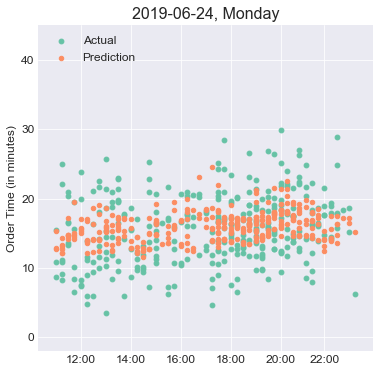

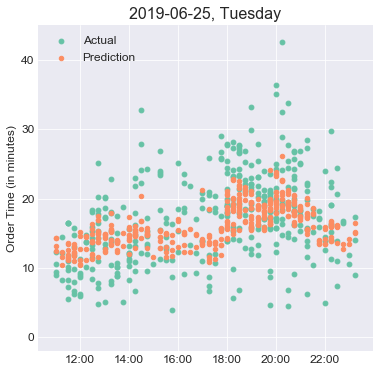

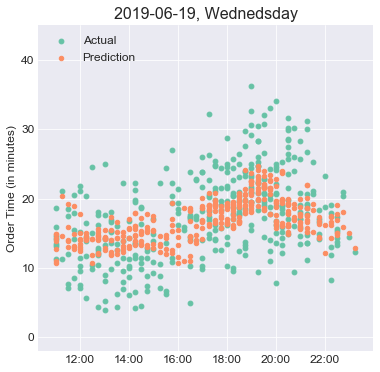

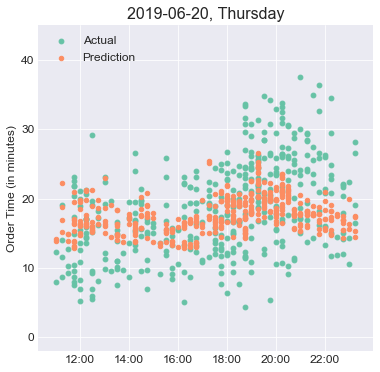

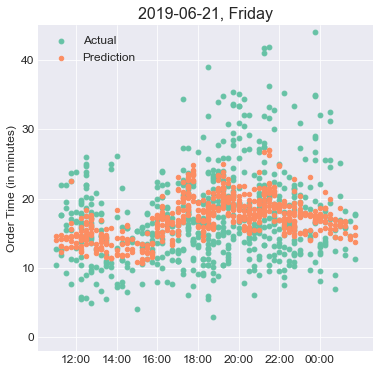

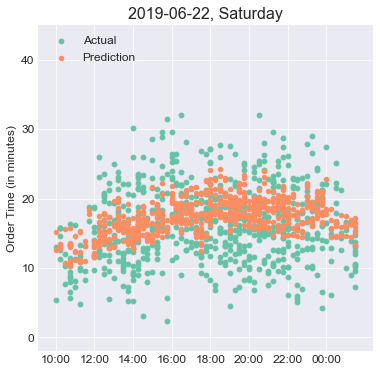

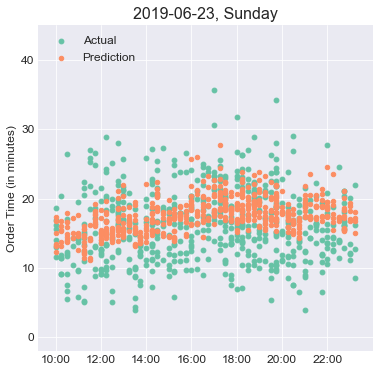

In [429]:
# Visualize: Prediction by Day-Time
w = ['Monday','Tuesday','Wednedsday','Thursday','Friday','Saturday','Sunday']
ot_data['OrderTime-Min'] = ot_data['OrderTime']/60
ot_data['pred-min'] =ot_data['pred']/60
ot_data['Label2'] = (ot_data['QuarterHour']%2==0)
for i in range(7):
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Set2')
    plt.figure(figsize=(6,6))
    
    d = ot_data[ot_data['DayOfWeek']==i].sort_values(by='QuarterHour')
    day = d['BusinessDate'].unique()[0].astype('str')[0:10]
    
    plt.scatter(d['StartTime'],d['OrderTime-Min'], color=palette(0), label='Actual',s=23)
    plt.scatter(d['StartTime'],d['pred-min'], color=palette(1), label='Prediction',s=20)
    
    plt.xticks(d['StartTime'][d['Label2']].unique())
    plt.title(str(day)+', '+w[i],fontsize=16)
    plt.legend(loc=2,fontsize=12)
    plt.ylabel('Order Time (in minutes)',fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(-2,45)

## Forecast

In [435]:
day_forecast = 5
time_forecast = 19
party_size = 2
#forecast = forecast[forecast['DayQuarterHour']==time_forecast] 

offsite = data[(data['QuarterHour']==time_forecast)&(data['DayOfWeek']==day_forecast)].groupby('QuarterHour').agg({'OffSiteOrder':'mean','OffSiteItem':'mean'})
r = float(offsite['OffSiteItem'] / offsite['OffSiteOrder'])
del offsite

offsite1 = pd.DataFrame([[i,(i*1)] for i in range(0,25,1)],columns=['OffSiteOrder','OffSiteItem'])
offsite5 = pd.DataFrame([[i,(i*5)] for i in range(0,25,1)],columns=['OffSiteOrder','OffSiteItem'])
offsite10 = pd.DataFrame([[i,(i*10)] for i in range(0,25,1)],columns=['OffSiteOrder','OffSiteItem'])

#var = ['OrderTime','DayOfWeek','QuarterHour','OffSiteOrder','OnSiteOrder','OnSiteItem','OffSiteItem','GuestCount','Class','OnSiteGuest']+labor_cat+labor_st
var = labor_cat + labor_st +['Class','OrderTime','DayOfWeek','QuarterHour','OnSiteOrder','OnSiteItem','OnSiteGuest','Holiday']
var_remove = ['OrderTime']
#forecast_data = data[(data['DayQuarterHour']==(pd.to_datetime(time_forecast)-pd.to_timedelta(7,unit='day')))|\
#                    (data['DayQuarterHour']==(pd.to_datetime(time_forecast)-pd.to_timedelta(14,unit='day')))].groupby('DayQuarterHour')[var].mean()
forecast_data = data[(data['DayOfWeek']==day_forecast)&(data['QuarterHour']==time_forecast)&(data['GuestCount']==party_size)].groupby('QuarterHour')[var].median()


In [436]:
#forecast_data['OnSiteOrder'] = float(forecast['OnSiteOrderPred'])
#forecast_data['OnSiteItem'] = float(forecast['OnSiteItemPred'])
#forecast_data['OnSiteGuest'] = float(forecast['OnSiteGuestPred'])
forecast_data1 = forecast_data.loc[forecast_data.index.repeat(len(offsite1))].reset_index(drop=True)
forecast_data1['OffSiteOrder'] = list(offsite1['OffSiteOrder'])
forecast_data1['OffSiteItem'] = list(offsite1['OffSiteItem'])
forecast_data1['GuestCount'] = party_size
forecast_reg1 = forecast_data1[reg_X.columns]
forecast_reg1_trans = scaler.transform(forecast_reg1)
forecast_data1['pred'] = gb.predict(forecast_reg1_trans)

forecast_data5 = forecast_data.loc[forecast_data.index.repeat(len(offsite5))].reset_index(drop=True)
forecast_data5['OffSiteOrder'] = list(offsite5['OffSiteOrder'])
forecast_data5['OffSiteItem'] = list(offsite5['OffSiteItem'])
forecast_data5['GuestCount'] = party_size
forecast_reg5 = forecast_data1[reg_X.columns]
forecast_reg5_trans = scaler.transform(forecast_reg5)
forecast_data5['pred'] = gb.predict(forecast_reg5_trans)

forecast_data10 = forecast_data.loc[forecast_data.index.repeat(len(offsite10))].reset_index(drop=True)
forecast_data10['OffSiteOrder'] = list(offsite10['OffSiteOrder'])
forecast_data10['OffSiteItem'] = list(offsite10['OffSiteItem'])
forecast_data10['GuestCount'] = party_size
forecast_reg10 = forecast_data10[reg_X.columns]
forecast_reg10_trans = scaler.transform(forecast_reg10)
forecast_data10['pred'] = gb.predict(forecast_reg10_trans)


Text(0,0.5,'Order Time (in minutes)')

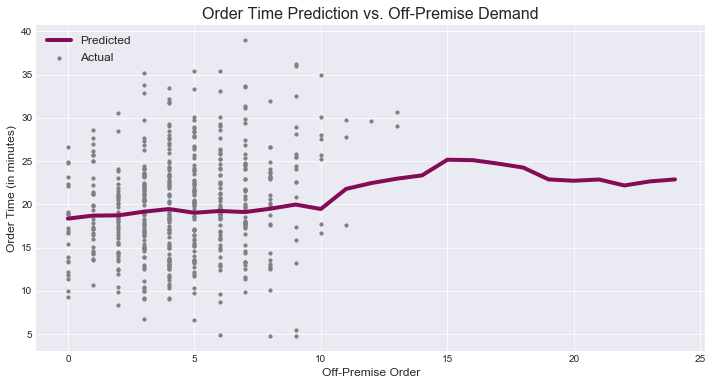

In [437]:
plt.style.use('seaborn-darkgrid')
forecast_data['OrderTime-Min'] = forecast_data['OrderTime']/60
forecast_data1['pred-min'] =forecast_data1['pred']/60
forecast_data5['pred-min'] =forecast_data5['pred']/60
forecast_data10['pred-min'] =forecast_data10['pred']/60

d = data[(data['DayOfWeek']==day_forecast)&(data['QuarterHour']==time_forecast)&(data['GuestCount']==party_size)]
# create a color palette
palette = plt.get_cmap('Set2')
plt.figure(figsize=(12,6))

plt.plot(forecast_data1['OffSiteOrder'],forecast_data1['pred-min'], color='#840b55', linewidth = 4,label='Predicted')
#plt.plot(forecast_data5['OffSiteOrder'],forecast_data5['pred-min'], color=palette(2), label='Prediction - Average Off-Premise Order Size 5')
#plt.plot(forecast_data10['OffSiteOrder'],forecast_data10['pred-min'], color=palette(3), label='Prediction - Average Off-Premise Order Size 10')
plt.scatter(d['OffSiteOrder'],d['OrderTime']/60,s=10,color='grey',label='Actual')

plt.title('Order Time Prediction vs. Off-Premise Demand',fontsize=16)

# Add legend
plt.legend(loc=2,fontsize=12) 
plt.xlabel('Off-Premise Order',fontsize=12)
plt.ylabel('Order Time (in minutes)',fontsize=12)

Text(0,0.5,'Order Time (in seconds)')

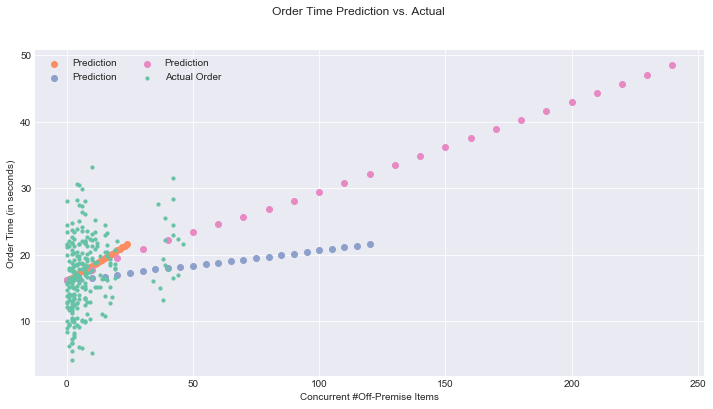

In [345]:
plt.style.use('seaborn-darkgrid')

d = data[(data['DayOfWeek']==day_forecast)&(data['QuarterHour']==time_forecast)&(data['GuestCount']==party_size)]
# create a color palette
palette = plt.get_cmap('Set2')
plt.figure(figsize=(12,6))

plt.scatter(forecast_data1['OffSiteItem'],forecast_data1['pred-min'], color=palette(1), label='Prediction')
plt.scatter(forecast_data5['OffSiteItem'],forecast_data5['pred-min'], color=palette(2), label='Prediction')
plt.scatter(forecast_data10['OffSiteItem'],forecast_data10['pred-min'], color=palette(3), label='Prediction')

plt.scatter(d['OffSiteItem'],d['OrderTime']/60,s=10,color=palette(0),label='Actual Order')

plt.suptitle('Order Time Prediction vs. Actual')

# Add legend
plt.legend(loc=2, ncol=2) 
plt.xlabel('Concurrent #Off-Premise Items')
plt.ylabel('Order Time (in seconds)')

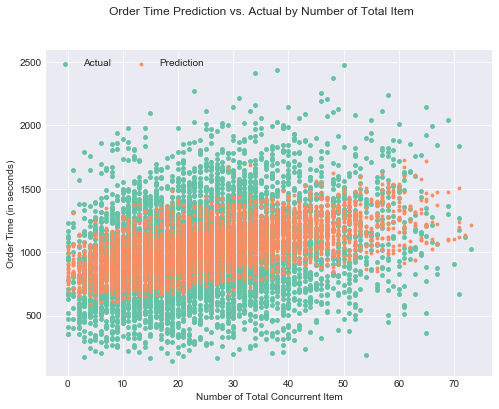

In [340]:
# Visualize
# style
plt.style.use('seaborn-darkgrid')
d=ot_data
# create a color palette
palette = plt.get_cmap('Set2')
plt.figure(figsize=(8,6))
plt.scatter(d['OnSiteItem']+d['OffSiteItem'],d['OrderTime'], color=palette(0), label='Actual',s=15)
plt.scatter(d['OnSiteItem']+d['OffSiteItem'],d['pred'], color=palette(1), label='Prediction',s=8)
plt.suptitle('Order Time Prediction vs. Actual by Number of Total Item')
plt.xlabel('Number of Total Concurrent Item')
plt.ylabel('Order Time (in seconds)')
plt.legend(loc=2, ncol=2) 